# setup

In [1]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [73]:
import pandas as pd
import wfdb
import matplotlib.pyplot as plt

from ecgprep import read_ecg, preprocess
from tqdm import tqdm

import numpy as np

In [97]:
ds_folder = 'lobachevsky-university-electrocardiography-database-1.0.1'
records = pd.read_csv(os.path.join(ds_folder, 'RECORDS'), header = None)
leads = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
symbols = ['N', 'p', 't']

# draft

In [142]:
for ii, row in tqdm(records.iterrows()):
    # read signal
    file_path = os.path.join(ds_folder, row[0])
    ecg, sample_rate, leads = read_ecg.read_ecg(file_path)

    # read annotations and prepare y
    y = np.zeros(shape = (len(leads), len(symbols), ecg.shape[1]))
    closed_flag = False
    for l, lead in enumerate(leads):
        ann = wfdb.rdann(file_path, extension = 'avf')
        assert len(ann.sample) == len(ann.symbol)

        for idx, symbol in enumerate(ann.symbol):
            if symbol not in symbols: # check if symbol is a letter
                continue
            
            # assert ann.symbol[idx - 1] == '(' and ann.symbol[idx + 1] == ')'
            if ann.symbol[idx - 1] != '(' or ann.symbol[idx + 1] != ')':
                closed_flag = True
            peak = ann.sample[idx] # check if is a closed wave and get onset and end of wave
            if ann.symbol[idx - 1] == '(':
                begin = ann.sample[idx - 1]
            else:
                begin = ann.sample[idx]
            if ann.symbol[idx + 1] == ')':
                end = ann.sample[idx + 1]
            else:
                end = ann.sample[idx]
            
            y[l, symbols.index(symbol), begin:end] = 1 # attribute 1 for closed wave in channel of corresponding symbol
    if closed_flag:
        print('file {} not in closed wave'.format(file_path))

99it [00:03, 27.10it/s]

file lobachevsky-university-electrocardiography-database-1.0.1/data/95 not in closed wave


108it [00:04, 26.66it/s]

file lobachevsky-university-electrocardiography-database-1.0.1/data/104 not in closed wave


114it [00:04, 26.75it/s]

file lobachevsky-university-electrocardiography-database-1.0.1/data/111 not in closed wave


200it [00:07, 26.94it/s]


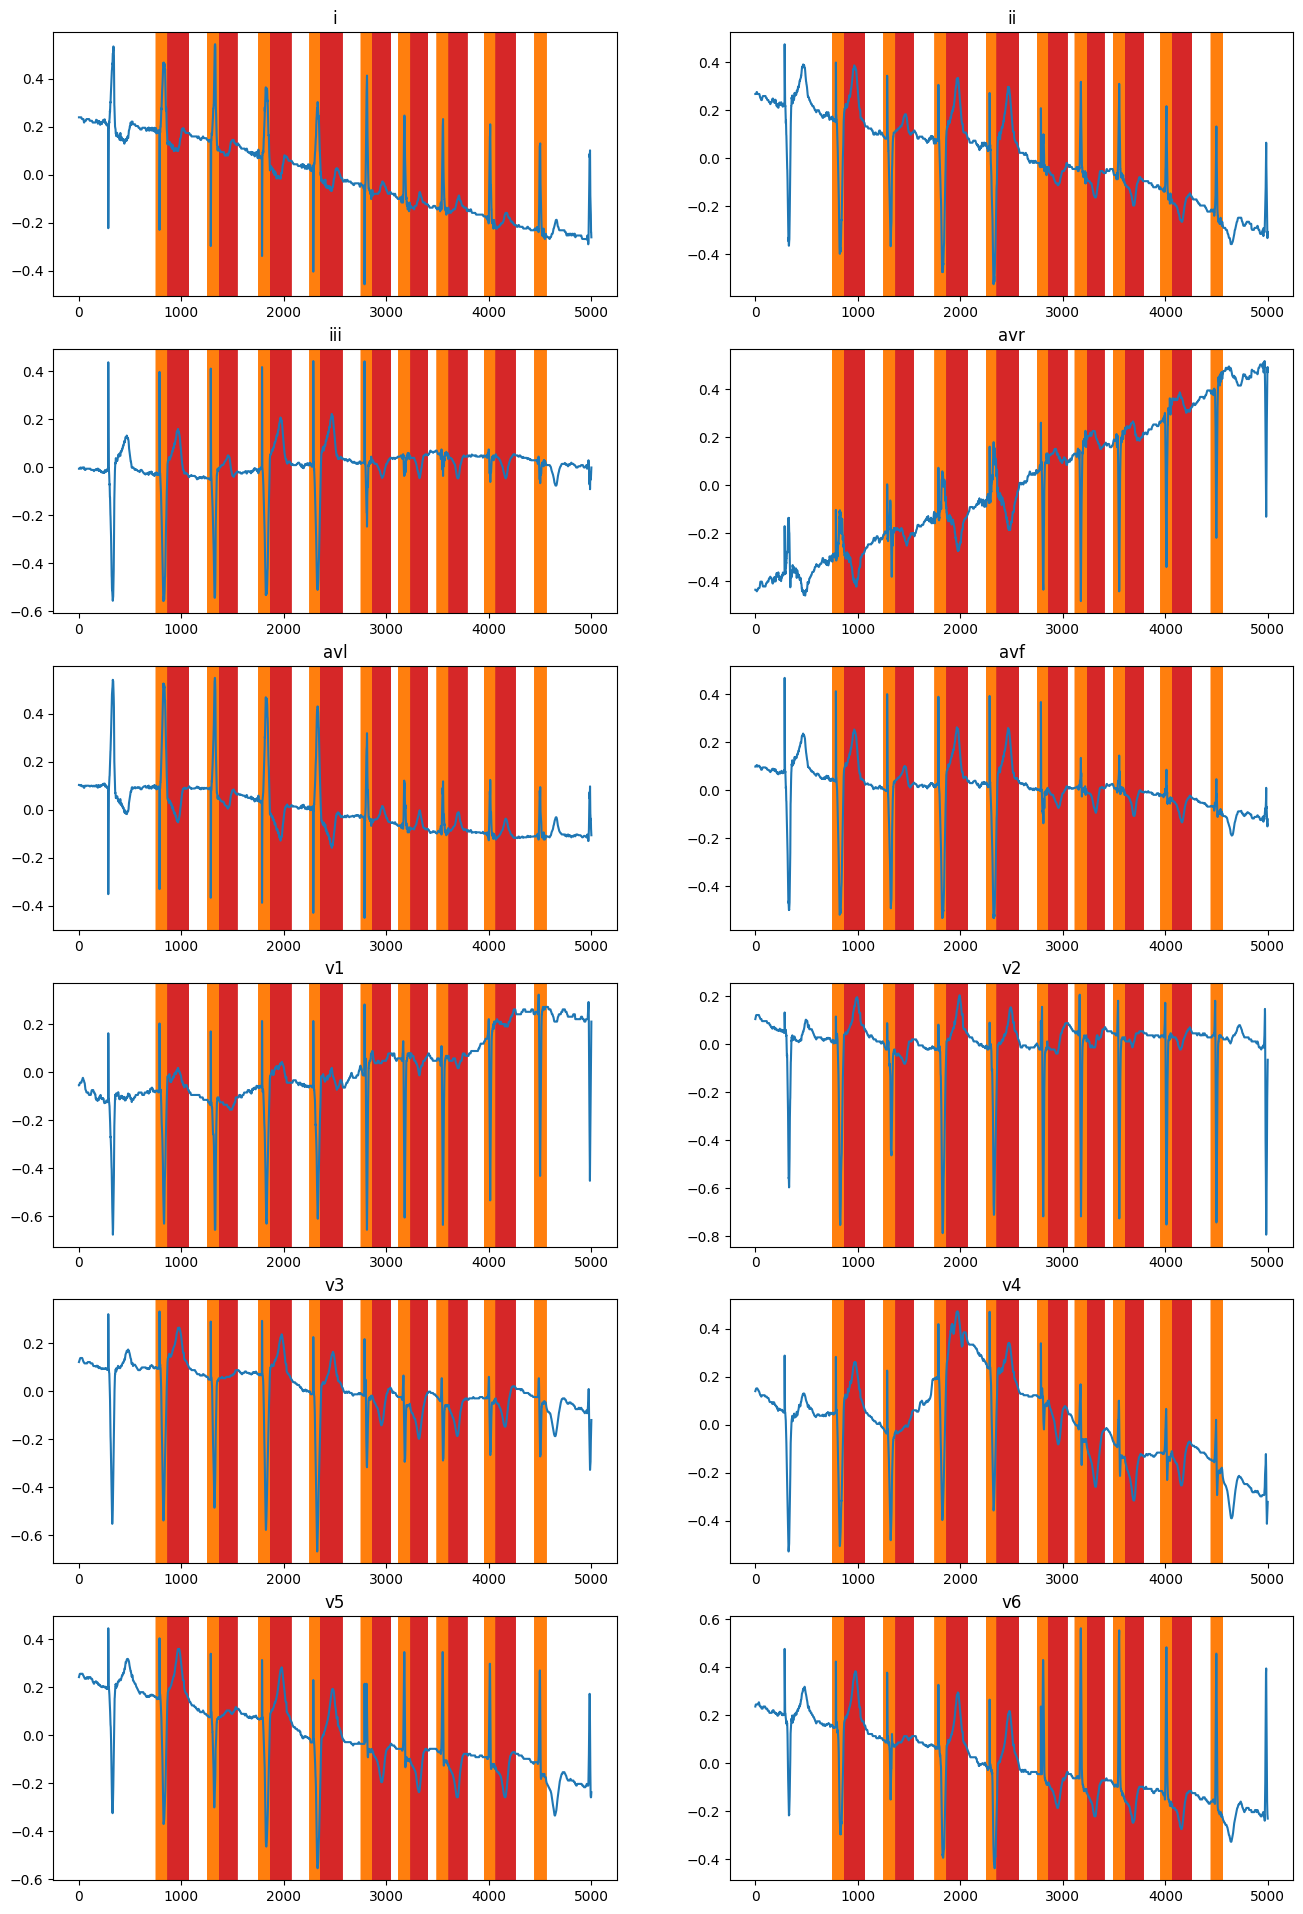

In [139]:
fig, axes = plt.subplots(6, 2, figsize = (16, 24))
index = np.linspace(0, ecg.shape[1] - 1, ecg.shape[1]);
colors = ['tab:orange', 'tab:green', 'tab:red']

contador = 0
for i in range(6):
    for j in range(2):
        for s in range(3):
            mask = y[contador, s, :] == 1
            axes[i, j].scatter(index[mask], y[contador, s, mask] - 1, marker = '_', color = colors[s], linewidths = 1000);
        
        axes[i, j].plot(ecg[contador, :]);
        axes[i, j].set_title(leads[contador]);
        contador += 1